# More Decision Tree learning with X-Fold Cross Validation and data Discretization

In [7]:
filepath = r"C:\Users\dufff\Course1\Demographic_Data.csv"
data = pd.read_csv(filepath)
data.head()

,in-store,age,items,amount,region
0,0,37,4,281.03,2
1,0,35,2,219.51,2
2,1,45,3,1525.70,4
3,1,46,3,715.25,3
4,1,33,4,1937.50,1


In [8]:
import numpy as np
import pandas as pd
# import pandas_profiling   # error message no moduled named pandas_profiling => new error message below
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

%matplotlib inline


# Q1: Are there differences in  age of customer between regions?  If so, can we predict the age of a customer in a region based on other demographic data

<function matplotlib.pyplot.show(close=None, block=None)>

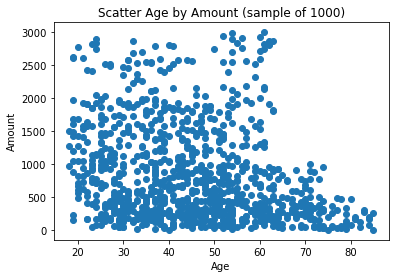

In [9]:
# EDA Age
data_sample = data.sample(1000)
x = data_sample['age']
y = data_sample['amount']
plt.scatter(x,y, marker = 'o')
plt.title('Scatter Age by Amount (sample of 1000)')
plt.ylabel('Amount')
plt.xlabel('Age')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

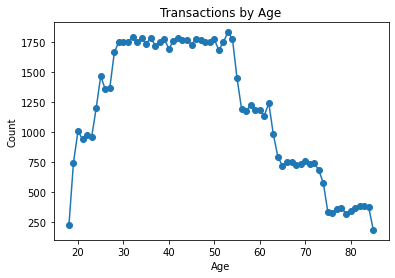

In [10]:
ageCount= data.groupby(['age'], as_index = False).count()   # "Index = False" flattens data stack
# ageCount
x = ageCount['age']
y = ageCount['amount']
plt.plot(x,y, marker = 'o')
plt.title('Transactions by Age')
plt.ylabel('Count')
plt.xlabel('Age')

plt.show


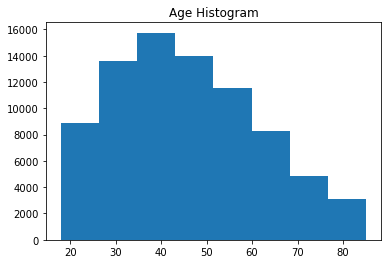

<function print>

In [11]:
plt.hist(data['age'], bins=8)
plt.title('Age Histogram')
plt.show()
print

age       43.0
region     1.0
dtype: float64
age       57.0
region     2.0
dtype: float64
age       45.0
region     3.0
dtype: float64
age       39.0
region     4.0
dtype: float64


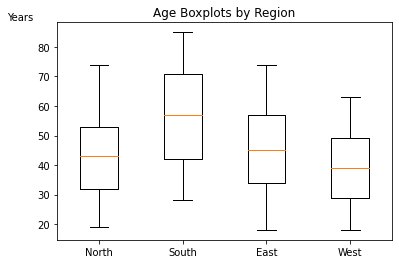

In [14]:
#Boxplot of Age for each Region in one figure.
#Slice data for Age and Region.
Rdata = data.iloc[:,[1,4]]
# print(Rdata) # check output
# Create datatable of age for each regions
North = Rdata.loc[Rdata['region'] == 1]
South = Rdata.loc[Rdata['region'] == 2]
East = Rdata.loc[Rdata['region'] == 3]
West = Rdata.loc[Rdata['region'] == 4]
print(North.median())
print(South.median()) #check output
print(East.median())
print(West.median())  # check output


# Create Datatable of just age column for each region for age
Nage = North['age']
Sage = South['age']
Eage = East['age']
Wage = West['age']
# print(Nage)  #check output

RegionAge = [Nage, Sage, Eage, Wage]
labels = ['North', 'South', 'East', 'West']
fig, ax = plt.subplots()
ax.set_title('Age Boxplots by Region')
ax.set_ylabel('Years', rotation=0, loc='top')
ax.boxplot(RegionAge, labels=labels)

plt.show()

Based on boxplot above appears there is statistical difference in age means/median for South region.  How to show this using decision tree modeling?....Strategy, break data into regions and test each data set to see if can develop a good model

Region Age Means t-test for significant difference of the region age means

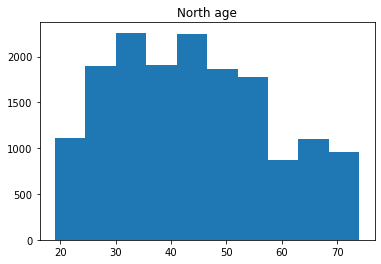

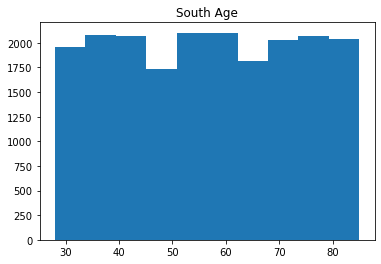

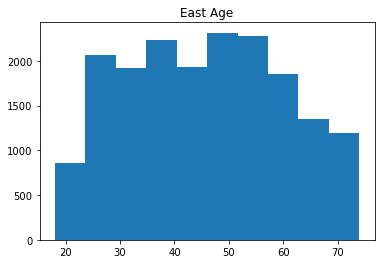

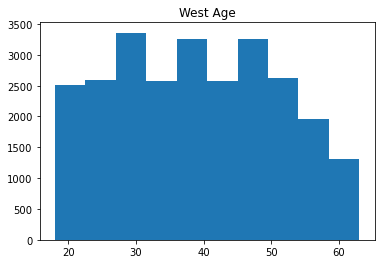

In [15]:
# Review age distribution of all regions

plt.hist(Nage, bins=10)
plt.title('North age')
plt.show()
plt.hist(Sage, bins=10)
plt.title('South Age')
plt.show()
plt.hist(Eage, bins=10)
plt.title('East Age')
plt.show()
plt.hist(Wage, bins=10)
plt.title('West Age')
plt.show()
print()
   

In [27]:
# Conduct means t-testing between each region

from scipy.stats import ttest_ind

def compare_2_groups(arr_1, arr_2, alpha, sample_size):
    stat, p = ttest_ind(arr_1,  arr_2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('Same distriputions (fail to reject the H0)')
    else:
        print('Different distribution (reject the H0)')

In [28]:
sample_size = 25
Nsample = np.random.choice(Nage, sample_size)
Ssample = np.random.choice(Sage, sample_size)
Esample = np.random.choice(Eage, sample_size)
Wsample = np.random.choice(Wage, sample_size)


print('South vs West')
compare_2_groups(Ssample, Wsample, 0.05, sample_size)
print()
print('South vs East')
compare_2_groups(Ssample, Esample, 0.05, sample_size)
print()
print('South vs North')
compare_2_groups(Ssample, Nsample, 0.05, sample_size)
print()
print('West vs East')
compare_2_groups(Ssample, Wsample, 0.05, sample_size)
print()
print('West vs North')
compare_2_groups(Ssample, Esample, 0.05, sample_size)
print()
print('East vs North')
compare_2_groups(Ssample, Nsample, 0.05, sample_size)
print()




South vs West
Statistics=4.467, p=0.000
Different distribution (reject the H0)

South vs East
Statistics=3.448, p=0.001
Different distribution (reject the H0)

South vs North
Statistics=3.557, p=0.001
Different distribution (reject the H0)

West vs East
Statistics=4.467, p=0.000
Different distribution (reject the H0)

West vs North
Statistics=3.448, p=0.001
Different distribution (reject the H0)

East vs North
Statistics=3.557, p=0.001
Different distribution (reject the H0)



Conclusion: t-test shows significant difference of age means between all regions with South region being largest "outlier"; however the data are not normally distributed for any of the regions...so taking results with a grain of salt. . 




In [18]:
# Correlation of Data
corr_mat = data.corr()
print(corr_mat)
print()
print()

# Covariance of Data
cov_mat = data.cov()
print(cov_mat)

          in-store       age     items    amount    region
in-store  1.000000 -0.178256 -0.003954 -0.085474 -0.133114
age      -0.178256  1.000000  0.000679 -0.282089 -0.235446
items    -0.003954  0.000679  1.000000  0.000367 -0.001925
amount   -0.085474 -0.282089  0.000367  1.000000  0.403504
region   -0.133114 -0.235446 -0.001925  0.403504  1.000000


           in-store          age     items         amount      region
in-store   0.250003    -1.400718 -0.004075     -30.825404   -0.074988
age       -1.400718   246.982562  0.021980   -3197.566591   -4.168901
items     -0.004075     0.021980  4.248703       0.545629   -0.004471
amount   -30.825404 -3197.566591  0.545629  520235.802331  327.903000
region    -0.074988    -4.168901 -0.004471     327.903000    1.269391


# Decision Tree Optimizing with Age as Dependent Variable    
  

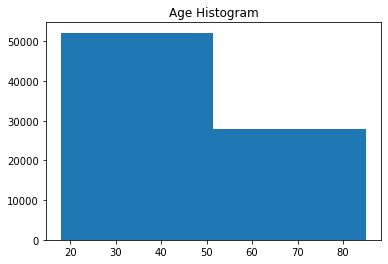

In [19]:
plt.hist(data['age'], bins=2)
plt.title('Age Histogram')
plt.show()

Note: Data Bins are Impalanced - adjust via class_weights in the algorithms

In [20]:
# Age Bins vs. In-Store and Region.....Age bins only 2 to get accuracy up.  
data['age_bin'] = pd.cut(data['age'], bins=2, labels=['1','2'])
X = data.iloc[:,[0,4]]
y = data['age_bin']
print(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

#Modeling weighting - moves accuracy about 6 pts upward.
weights = {'1':1.0,
           '2':1.5,}

algo = DecisionTreeClassifier(max_depth=4, class_weight=weights)
model = algo.fit(X_train,y_train)

preds = model.predict(X_test)  #Predictions

print(classification_report(y_test, preds, zero_division=True))


       in-store  age  items   amount  region age_bin
0             0   37      4   281.03       2       1
1             0   35      2   219.51       2       1
2             1   45      3  1525.70       4       1
3             1   46      3   715.25       3       1
4             1   33      4  1937.50       1       1
...         ...  ...    ...      ...     ...     ...
79995         1   71      3   558.82       1       2
79996         0   59      7  1932.00       3       2
79997         0   54      1   414.16       2       2
79998         1   49      4   335.32       1       1
79999         1   30      1   527.12       3       1

[80000 rows x 6 columns]
              precision    recall  f1-score   support

           1       0.78      0.73      0.75     15778
           2       0.54      0.61      0.57      8222

    accuracy                           0.69     24000
   macro avg       0.66      0.67      0.66     24000
weighted avg       0.70      0.69      0.69     24000



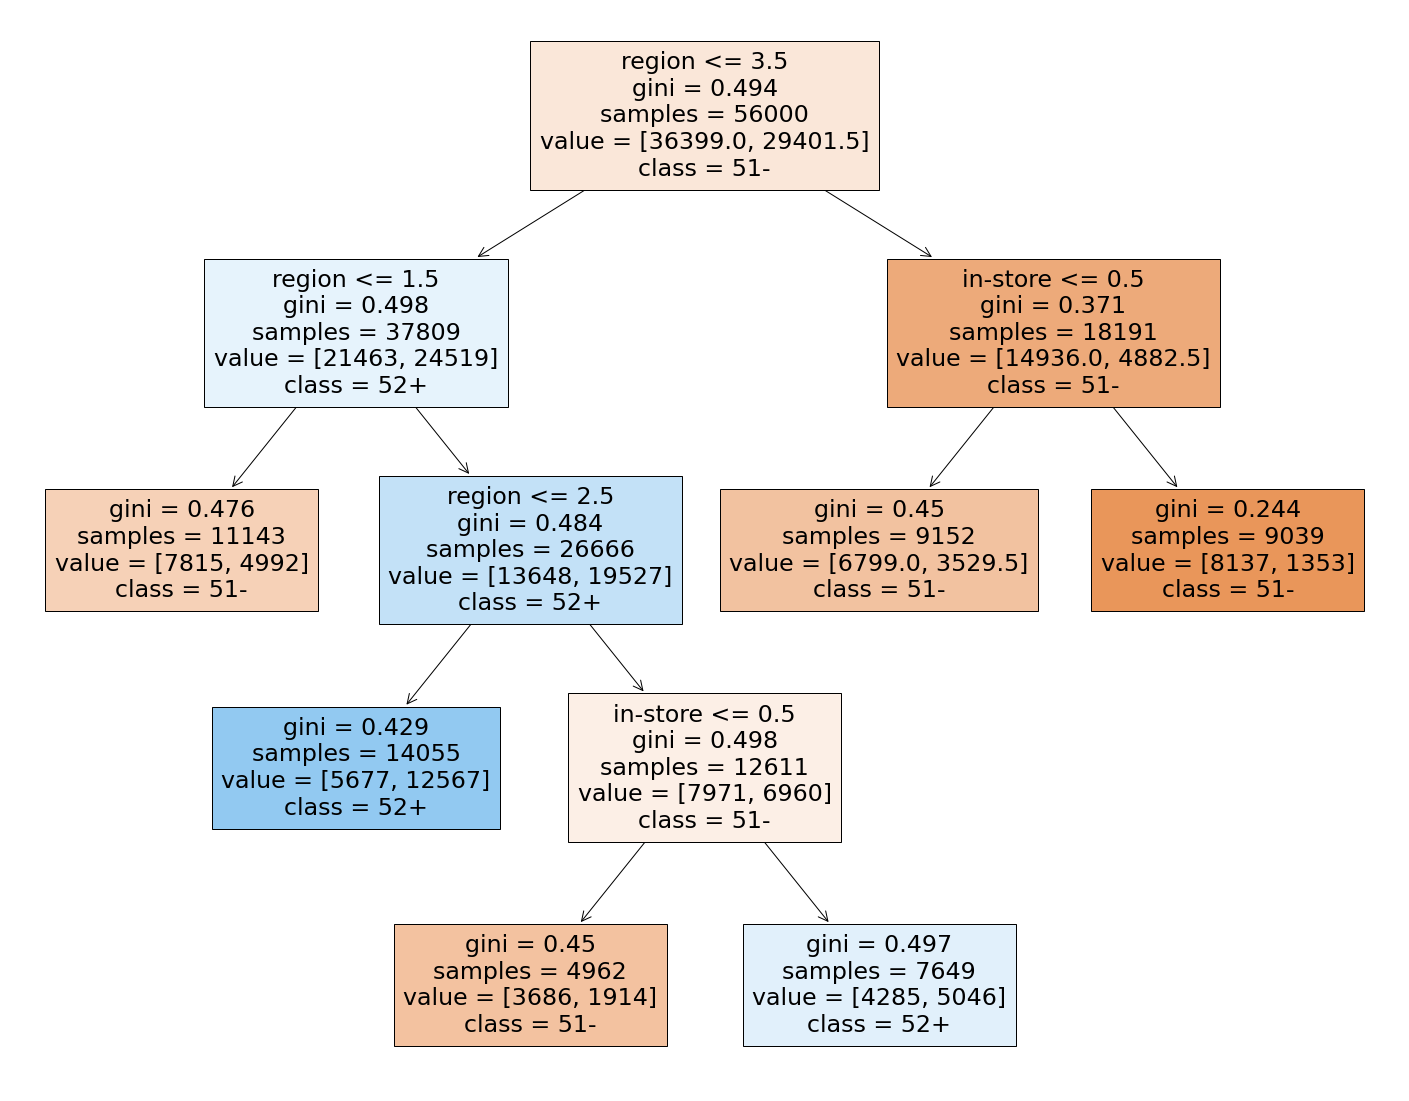

In [21]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(25,20))
tree = plot_tree(model, feature_names=X.columns, class_names=['51-','52+'], filled=True)

Compare against other algo Random Forrest Classifier

In [22]:
# RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

# Model weighting reduces accuracy in RandomForest by 2pts.
# weights = {'1':1.0,
#            '2':1.5,}

algo = RandomForestClassifier(max_depth=3)
model = algo.fit(X_train,y_train)

preds = model.predict(X_test)  #Predictions

print(classification_report(y_test, preds, zero_division=True))


              precision    recall  f1-score   support

           1       0.74      0.84      0.79     15778
           2       0.58      0.42      0.49      8222

    accuracy                           0.70     24000
   macro avg       0.66      0.63      0.64     24000
weighted avg       0.68      0.70      0.68     24000



### Cross Validation & Comparison between DecisionTreeClassifier vs. RandomForestClassifier

In [85]:
# DecisionTreeClassifier Cross Validation - 3 folds

model = DecisionTreeClassifier(max_depth=4, class_weight=weights)
print(cross_val_score(model, X, y, cv=3))  # cv = number of folds held out

# print(classification_report(y_test, preds, zero_division=True))



[0.68361645 0.68530393 0.67962949]


In [86]:
# RandomForestClassiter Cross Validation - 3 folds
model = RandomForestClassifier(max_depth=4)
print(cross_val_score(model, X, y, cv=3))  # cv = number of folds held out

[0.69794128 0.70191623 0.69492987]


In [87]:
# Cross Validation / comparision of the two alogrithms -  3 folds.
algos_Class = []
algos_Class.append(('Random Forest Classifier', RandomForestClassifier(max_depth=4, class_weight=weights)))
algos_Class.append(('Decision Tree Classifier', DecisionTreeClassifier(max_depth=4)))

# Classification
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i], results[i].mean())

Random Forest Classifier 0.6828499597441374
Decision Tree Classifier 0.6982624583426862


# For age dependent variable: best model fit I could achieve is an accuracy of 69% with Decision Tree Classifier:  Optimization steps included Max_depth = 4, adjusting the class weights and Descritize Age to 2 buckets (51yrs',  >51yrs) and limiting independent varibles (X) to two: region and in/store.     

# Q2: Is there any correlation between age of a customer and if the transaction was made onlin or in the store?  Or do other factors correlate to an online or in-store tranasaction

# Decision Tree Optimization with On-Line as Dependent Variable

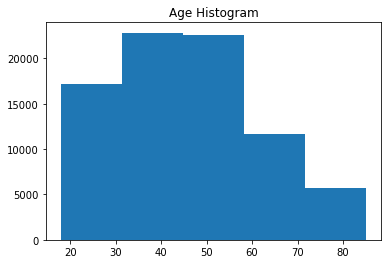

<function print>

In [23]:
plt.hist(data['age'], bins=5)
plt.title('Age Histogram')
plt.show()
print

In [24]:
data

,in-store,age,items,amount,region,age_bin
0,0,37,4,281.03,2,1
1,0,35,2,219.51,2,1
2,1,45,3,1525.70,4,1
3,1,46,3,715.25,3,1
4,1,33,4,1937.50,1,1
...,...,...,...,...,...,...
79995,1,71,3,558.82,1,2
79996,0,59,7,1932.00,3,2
79997,0,54,1,414.16,2,2
79998,1,49,4,335.32,1,1


In [25]:
# In-Store vs Region and Age-Bins

data['age_bin'] = pd.cut(data['age'], bins=5, labels=['1','2','3','4','5'])
X = data.iloc[:,[4,5]]
# print(X)
y = data['in-store']
# print(y)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

#Modeling (Classification)
algo = DecisionTreeClassifier(max_depth=5)
model = algo.fit(X_train,y_train)

preds = model.predict(X_test)  #Predictions

print(classification_report(y_test, preds, zero_division=True))

# '18-31','32-45','45-58','59-73','73+'

              precision    recall  f1-score   support

           0       0.84      0.68      0.75     11831
           1       0.74      0.87      0.80     12169

    accuracy                           0.78     24000
   macro avg       0.79      0.78      0.78     24000
weighted avg       0.79      0.78      0.78     24000



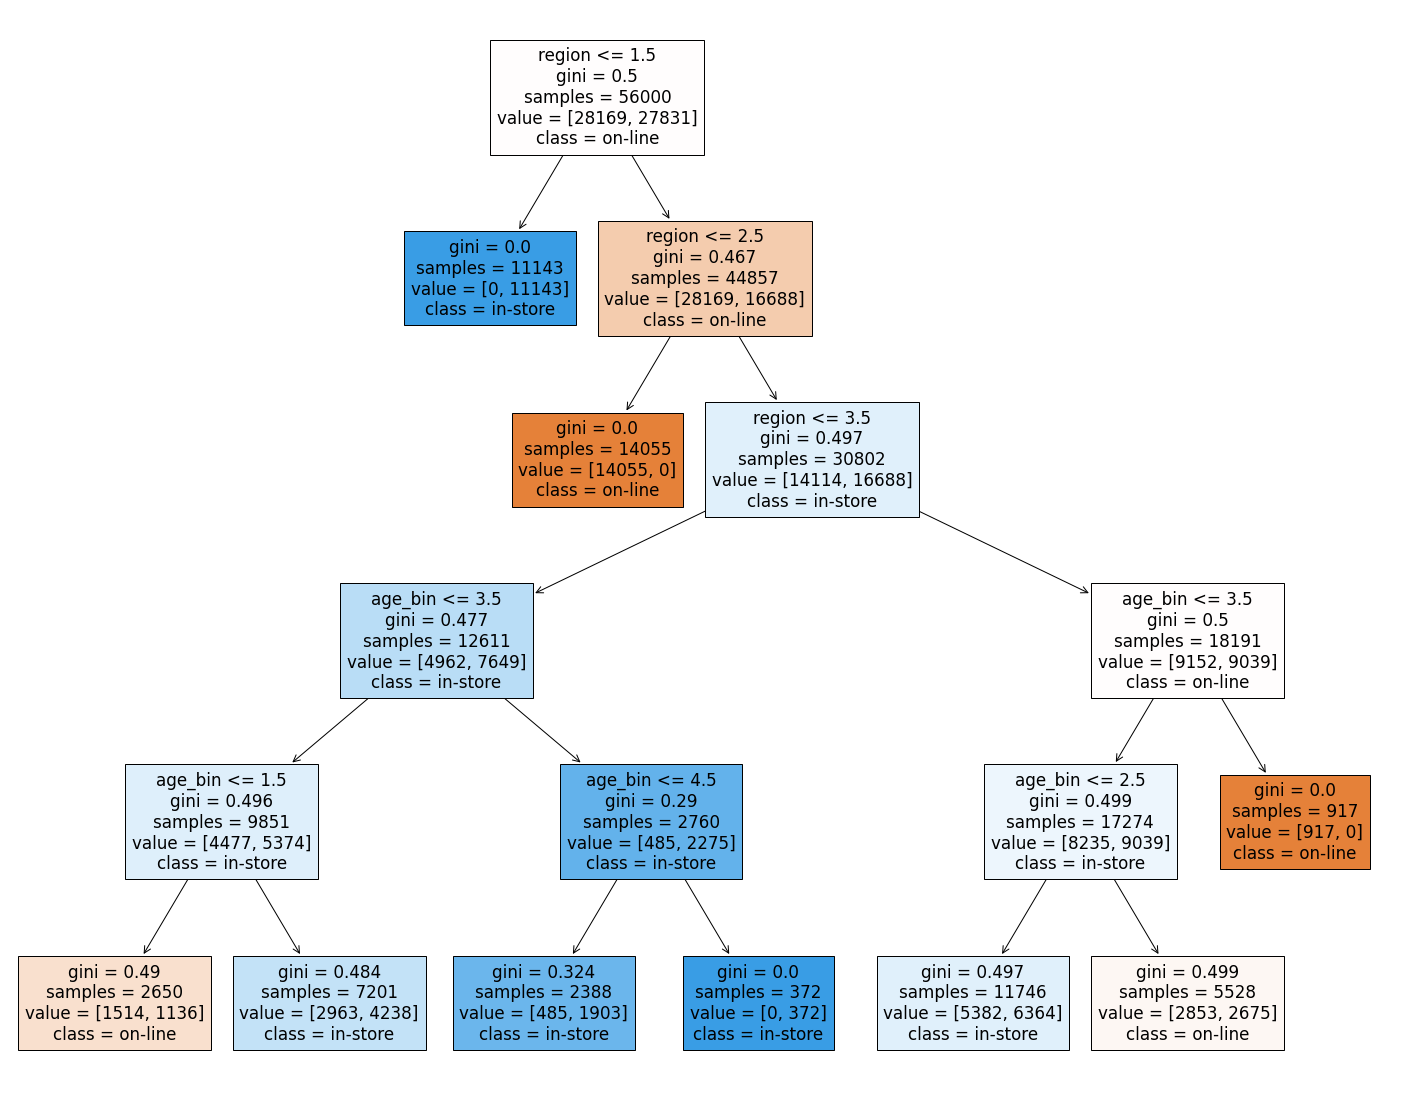

In [26]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(25,20))
tree = plot_tree(model, feature_names=X.columns, class_names=['on-line','in-store'], filled=True)

# This tree fell inline much easier.  Achieved an accuracy of .78 with higher age discretization of Age (5 bins).  No class-weighting required.  Depth = 4.

In [8]:
%lsmagic
    

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %conda  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python 

In [10]:
%pwd


'C:\\Users\\dufff\\Course1'

In [11]:
%ls

 Volume in drive C is OS
 Volume Serial Number is 981C-355C

 Directory of C:\Users\dufff\Course1

04/04/2022  04:56 PM    <DIR>          .
04/02/2022  11:06 AM    <DIR>          ..
04/01/2022  08:23 AM    <DIR>          .ipynb_checkpoints
03/15/2022  02:37 PM            61,660 C1_Task1-Customer Buying Patterns.pptm
03/29/2022  11:46 AM           400,287 C1T1 Workbook.ipynb
04/04/2022  08:43 AM         2,581,452 C1T2 Decision-Tree-Analysis.ipynb
04/04/2022  04:56 PM           693,320 C1T2 Workbook.ipynb
03/03/2022  08:22 PM         1,348,525 Demographic_Data.csv
03/23/2022  03:49 PM         1,348,525 Demographic_Data-Copy1.csv
03/13/2022  07:53 AM         3,781,029 Fremont_Bridge_Bicycle_Counter.csv
04/02/2022  08:03 PM           210,254 model.png
04/02/2022  08:03 PM           290,154 rf_individualtree.png
               9 File(s)     10,715,206 bytes
               3 Dir(s)  377,498,767,360 bytes free
